IMPORT LIBRARIES

In [23]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder # Encoding with categorical data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer # Filling in null values for numeric data
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
from pulp import LpMaximize, LpProblem, LpVariable,LpStatus
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report

EDA

In [2]:
#reading the data
df = pd.read_csv('loan_default_1_smpl.csv')
df.head(2)

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0


In [3]:
#checking null percentage if nulls are present in that column
nulls = df.isna().mean()[df.isna().mean().sort_values(ascending=False)!=0].sort_values(ascending=False) * 100
print(nulls)
print('\n\nTotal no of columns has null values:',len(nulls))

dtir1                        9.334143
Upfront_charges              8.753771
income                       6.821991
Interest_rate_spread         6.174573
rate_of_interest             6.136859
property_value               2.600151
LTV                          2.600151
loan_limit                   2.285870
approv_in_adv                0.590848
loan_purpose                 0.098475
Neg_ammortization            0.092189
age                          0.037714
submission_of_application    0.037714
term                         0.025142
dtype: float64


Total no of columns has null values: 14


In [4]:
#Distribution of target variable
print(df['Status'].value_counts())

Status
0    44781
1     2947
Name: count, dtype: int64


Note 1: There are more loans which are paid(94%) which means the dataset is imbalanced. 
    This will skew the predictions.

In [5]:
df.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,47728.000000,47728.0,4.772800e+04,44799.000000,44781.000000,43550.000000,47716.000000,4.648700e+04,44472.000000,47728.000000,46487.000000,47728.000000,43273.000000
mean,99302.163384,2019.0,3.347281e+05,4.042953,0.443168,3245.245579,335.207100,5.046378e+05,7118.696708,699.779605,72.370258,0.061746,37.472558
std,42959.157668,0.0,1.775746e+05,0.559457,0.511409,3268.411650,58.503586,3.505760e+05,5944.912024,115.735665,48.155532,0.240696,10.150690
min,24891.000000,2019.0,1.650000e+04,2.500000,-1.047000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,2.767587,0.000000,5.000000
25%,62022.500000,2019.0,2.065000e+05,3.625000,0.077300,600.000000,360.000000,2.780000e+05,3900.000000,599.000000,60.279605,0.000000,31.000000
50%,99556.000000,2019.0,3.065000e+05,3.990000,0.392000,2634.735000,360.000000,4.280000e+05,5940.000000,700.000000,74.641577,0.000000,39.000000
75%,136384.500000,2019.0,4.465000e+05,4.375000,0.776600,4820.255000,360.000000,6.280000e+05,8700.000000,800.000000,85.472973,0.000000,44.000000
max,173559.000000,2019.0,2.506500e+06,7.500000,2.636800,53485.780000,360.000000,9.268000e+06,329460.000000,900.000000,6706.250000,1.000000,61.000000


In [6]:
#manipulating the columns and grouping the catgorical and numerical columns
df_a = df.drop(['ID','year'],axis=1)
df_a['Status'] = df_a['Status'].astype('object')

dtypes = pd.DataFrame(df_a.dtypes).reset_index()

cat_vars = []
num_vars = []
for i, l in zip(dtypes['index'], dtypes[0]):
    if l == 'object':
        cat_vars.append(i)
    else:
        num_vars.append(i)
print(cat_vars,'\n\n\n',num_vars)

['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type', 'Status'] 


 ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']


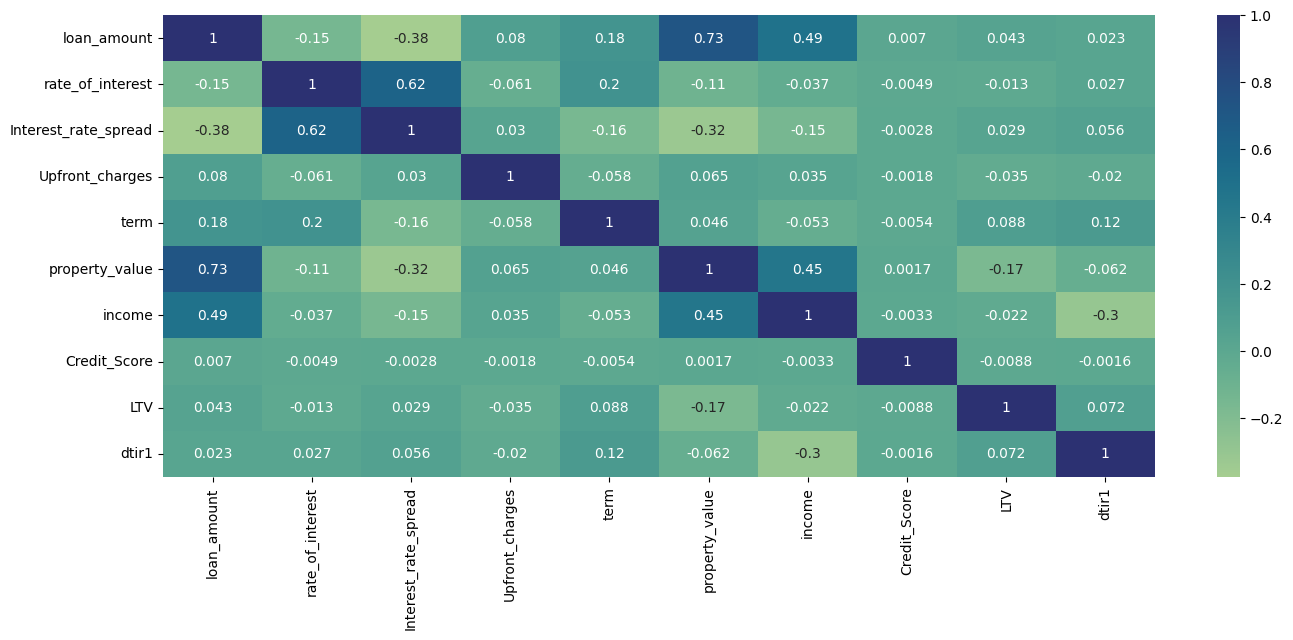

In [8]:
#knn imputation and heat map between target and numerical columns
df_num = df_a[num_vars]
knn = KNNImputer(n_neighbors=3)
df_num_imputed = knn.fit_transform(df_num)
df_num = pd.DataFrame(df_num_imputed, columns=num_vars)
corr = df_num.corr()


# Correlation Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr, annot=True,cmap='crest')

Interpretation:
loan amount is highly correlated with property value and income, inversely correlated with interest rate spread.
income and property value are also correlated to each other.

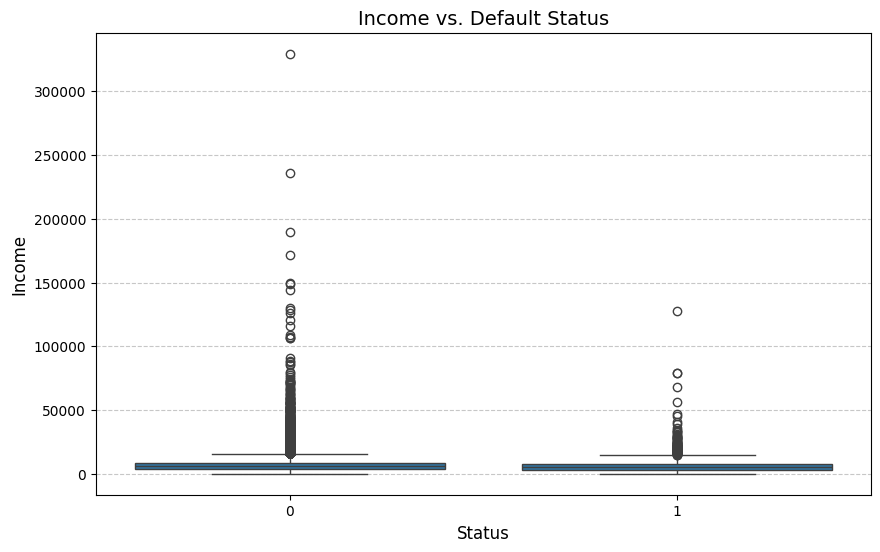

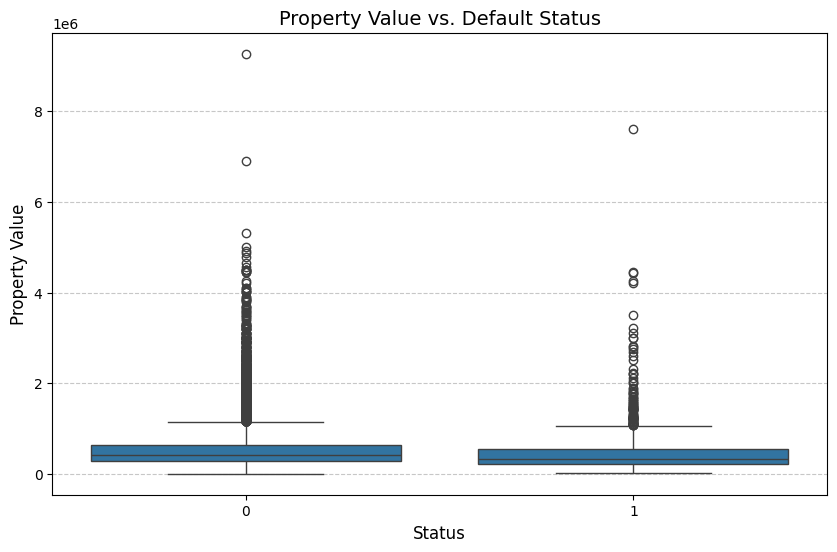

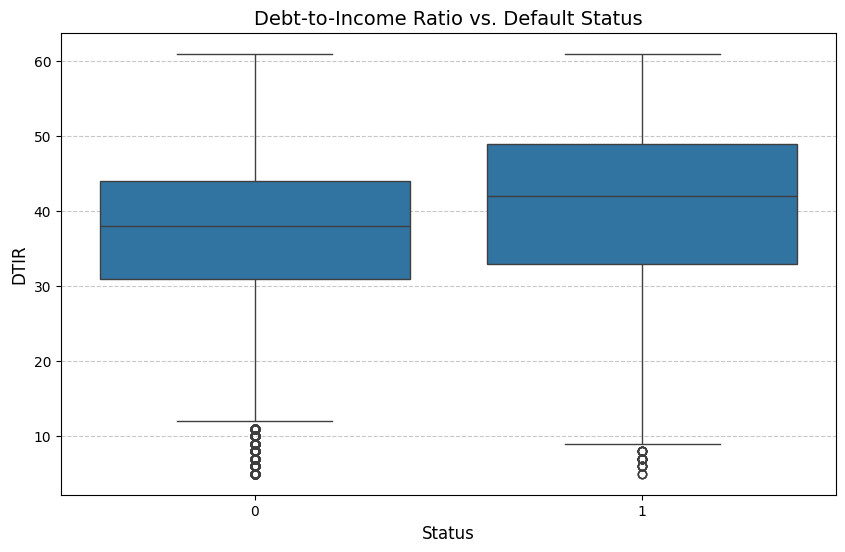

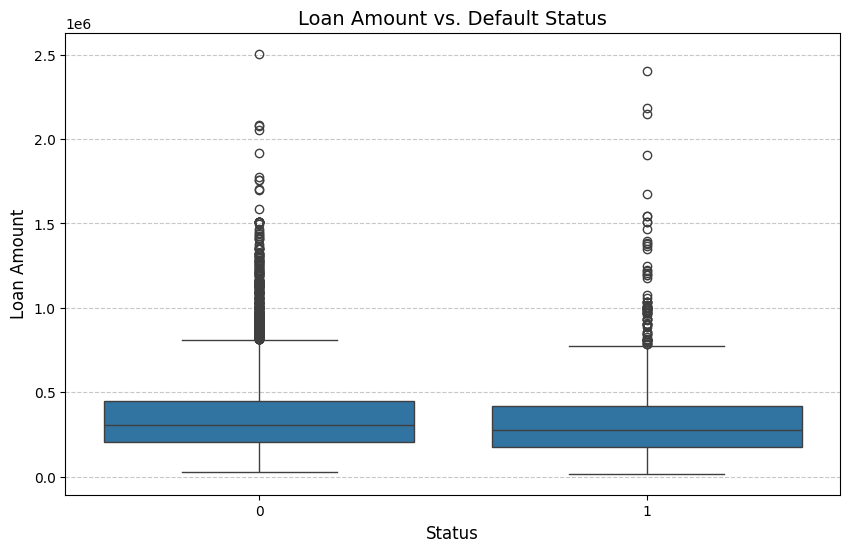

In [9]:
def plot_vs_status(data, column, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Status", y=column, data=data)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Plot Income vs. Status
plot_vs_status(df_a, "income", "Income vs. Default Status", "Status", "Income")

# Plot Property Value vs. Status
plot_vs_status(df, "property_value", "Property Value vs. Default Status", "Status", "Property Value")

# Plot DTIR vs. Status
plot_vs_status(df, "dtir1", "Debt-to-Income Ratio vs. Default Status", "Status", "DTIR")

# Plot Loan Amount vs. Status
plot_vs_status(df, "loan_amount", "Loan Amount vs. Default Status", "Status", "Loan Amount")


CONCLUSIONS:
high income persons are not defaulters most of the cases.
high property value is not tend to be defaulters.
Median dtir,IQR box is slightly higher in defaulters, i.e., DTIR values for defaulters vary more significantly.
high median loan amount for non-defaulters compared to defaulters suggests that high loan amount is correlated with no defaults.

ASSUMPTIONS(CATEGORICAL)
1. How likely lump_sum_payment recievers are turning out a defaulter.

2. Which credit type is not reliable, more defaulters.

2. Default percentage is skewed to any gender?

3. loan types & loan purpose causing the default?

4. age of the applicant has any impact on credit default?

In [10]:
# Calculate default rates for lump_sum_payment receivers vs non-receivers
lump_sum_defaults = df.groupby("lump_sum_payment")["Status"].mean()
lump_sum_counts = df.groupby("lump_sum_payment")["Status"].count()

print("Default Rates by Lump Sum Payment:")
print(lump_sum_defaults)

print("\nCount of Lump Sum Payment Receivers:")
print(lump_sum_counts)


Default Rates by Lump Sum Payment:
lump_sum_payment
lpsm        0.414449
not_lpsm    0.057815
Name: Status, dtype: float64

Count of Lump Sum Payment Receivers:
lump_sum_payment
lpsm          526
not_lpsm    47202
Name: Status, dtype: int64


In [11]:
# Calculate default percentages for each credit type
credit_type_defaults = df.groupby("credit_type")["Status"].mean()
credit_type_counts = df.groupby("credit_type")["Status"].count()

print("Default Rates by Credit Type:")
print(credit_type_defaults)

print("\nCount of Borrowers by Credit Type:")
print(credit_type_counts)


Default Rates by Credit Type:
credit_type
CIB     0.036079
CRIF    0.036933
EQUI    0.999206
EXP     0.035966
Name: Status, dtype: float64

Count of Borrowers by Credit Type:
credit_type
CIB     16824
CRIF    15325
EQUI     1260
EXP     14319
Name: Status, dtype: int64


In [12]:
# Calculate default rates for each gender
gender_defaults = df.groupby("Gender")["Status"].mean()
gender_counts = df.groupby("Gender")["Status"].count()

print("Default Rates by Gender:")
print(gender_defaults)

print("\nCount of Borrowers by Gender:")
print(gender_counts)


Default Rates by Gender:
Gender
Female               0.060184
Joint                0.046414
Male                 0.068319
Sex Not Available    0.073744
Name: Status, dtype: float64

Count of Borrowers by Gender:
Gender
Female                8690
Joint                13983
Male                 13393
Sex Not Available    11662
Name: Status, dtype: int64


In [13]:
# Default rates by Loan_Type
loan_type_defaults = df.groupby("loan_type")["Status"].mean()
loan_type_counts = df.groupby("loan_type")["Status"].count()

print("Default Rates by Loan Type:")
print(loan_type_defaults)

# Default rates by Loan_Purpose
loan_purpose_defaults = df.groupby("loan_purpose")["Status"].mean()
loan_purpose_counts = df.groupby("loan_purpose")["Status"].count()

print("\nDefault Rates by Loan Purpose:")
print(loan_purpose_defaults)


Default Rates by Loan Type:
loan_type
type1    0.055094
type2    0.097826
type3    0.067478
Name: Status, dtype: float64

Default Rates by Loan Purpose:
loan_purpose
p1    0.063634
p2    0.099507
p3    0.063059
p4    0.057085
Name: Status, dtype: float64


In [14]:
# Create age bins for categorization
# Default rates by age bins
age_defaults = df.groupby("age")["Status"].mean()
age_counts = df.groupby("age")["Status"].count()

print("Default Rates by Age Group:")
print(age_defaults)

print("\nCount of Borrowers by Age Group:")
print(age_counts)


Default Rates by Age Group:
age
25-34    0.057001
35-44    0.053149
45-54    0.058808
55-64    0.062848
65-74    0.074239
<25      0.079137
>74      0.079777
Name: Status, dtype: float64

Count of Borrowers by Age Group:
age
25-34     6228
35-44    10894
45-54    11087
55-64    10422
65-74     6506
<25        417
>74       2156
Name: Status, dtype: int64


CONCLUSIONS:
lumpsum loans are risky.
Equifax credit reports are not so reliable.
Genders,region, loan type, age are not so relevant.

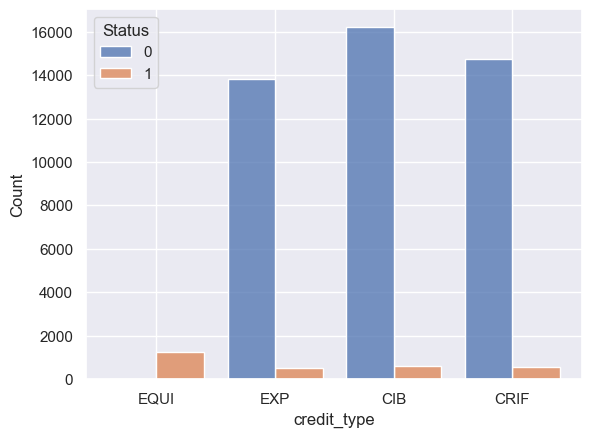

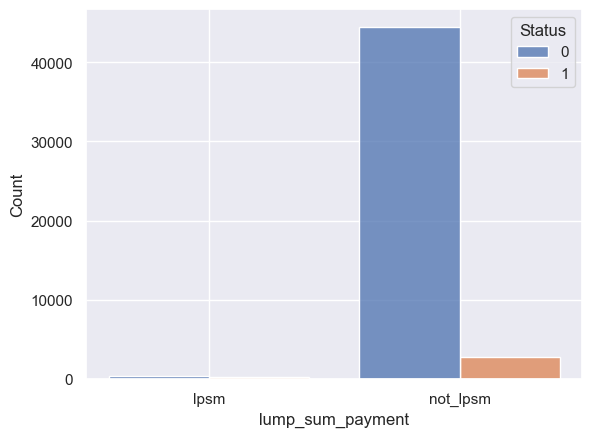

In [15]:
def plot_hist(col):
    plt.figsize=(12,4)
    sns.set_theme(style='darkgrid')
    sns.histplot(data=df, x=col, hue="Status", multiple="dodge", shrink=.8, stat='count')
    plt.show()


# Gender
plot_hist(df['credit_type'])

# Lump sum payment
plot_hist(df['lump_sum_payment'])




1. MODEL PIPELINE: PREDICITING THE LIKELIHOOD OF DEFAULTS.

XGBoost Accuracy: 0.935679865912424
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      8957
           1       0.49      0.75      0.59       589

    accuracy                           0.94      9546
   macro avg       0.73      0.85      0.78      9546
weighted avg       0.95      0.94      0.94      9546

Train Accuracy: 0.9217144930772666
Test Accuracy: 0.935679865912424


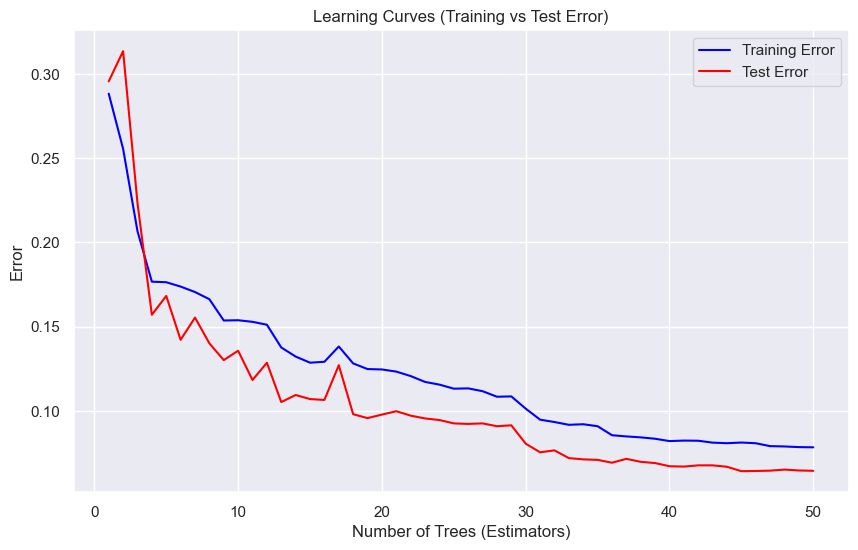

In [24]:
class DataPipeline:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None
        self.df_full = None
        self.cat_vars = []
        self.num_vars = []

    def load_data(self):
        self.df = pd.read_csv(self.file_path)
        self.df = self.df.drop(['ID', 'year'], axis=1)
        self.df['Status'] = self.df['Status'].astype('object')

    def identify_variables(self):
        dtypes = pd.DataFrame(self.df.dtypes).reset_index()
        for col, dtype in zip(dtypes['index'], dtypes[0]):
            if dtype == 'object':
                self.cat_vars.append(col)
            else:
                self.num_vars.append(col)

    def impute_missing_values(self):
        # Numerical imputation
        df_num = self.df[self.num_vars]
        knn = KNNImputer(n_neighbors=3)
        df_num_imputed = knn.fit_transform(df_num)
        df_num = pd.DataFrame(df_num_imputed, columns=self.num_vars)

        # Categorical imputation
        df_cat = self.df[self.cat_vars]
        for col in self.cat_vars:
            mode = df_cat[col].mode()[0]
            df_cat[col].fillna(value=mode, inplace=True)

        self.df_full = pd.concat([df_num, df_cat], axis=1, join='inner')

    def encode_variables(self):
        # Label encoding for all categorical variables
        label = LabelEncoder()
        for col in self.cat_vars:
            if col in self.df_full.columns:  # Ensure the column exists
                self.df_full[col] = label.fit_transform(self.df_full[col].astype(str))

    def scale_features(self):
        scaler = RobustScaler()
        numeric_cols = self.df_full.select_dtypes(include=['float64', 'int64']).columns
        self.df_full[numeric_cols] = scaler.fit_transform(self.df_full[numeric_cols])

    def split_and_balance_data(self):
        train_set, test_set = train_test_split(self.df_full, test_size=0.2, random_state=42)
        y_train = train_set['Status']
        X_train = train_set.drop(columns=['Status'])
        y_test = test_set['Status']
        X_test = test_set.drop(columns=['Status'])

        smote = SMOTE(random_state=40)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        return X_train_res, y_train_res, X_test, y_test

    def train_and_evaluate_model(self, X_train_res, y_train_res, X_test, y_test):
        xgb_model = XGBClassifier(random_state=42, n_estimators=50, max_depth=2, enable_categorical=True)
        xgb_model.fit(X_train_res, y_train_res)
        y_pred_xgb = xgb_model.predict(X_test)

        print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
        print(classification_report(y_test, y_pred_xgb))

        y_train_pred = xgb_model.predict(X_train_res)
        train_accuracy = accuracy_score(y_train_res, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_pred_xgb)
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        return xgb_model

    def plot_learning_curves(self, X_train_res, y_train_res, X_test, y_test):
        train_errors, test_errors = [], []
        for n_estimators in range(1, 51):
            xgb_model = XGBClassifier(random_state=42, n_estimators=n_estimators, max_depth=2,enable_categorical=True)
            xgb_model.fit(X_train_res, y_train_res)

            train_errors.append(1 - accuracy_score(y_train_res, xgb_model.predict(X_train_res)))
            test_errors.append(1 - accuracy_score(y_test, xgb_model.predict(X_test)))

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, 51), train_errors, label="Training Error", color='blue')
        plt.plot(range(1, 51), test_errors, label="Test Error", color='red')
        plt.xlabel("Number of Trees (Estimators)")
        plt.ylabel("Error")
        plt.title("Learning Curves (Training vs Test Error)")
        plt.legend()
        plt.grid(True)
        plt.show()

# Usage
pipeline = DataPipeline('loan_default_1_smpl.csv')
pipeline.load_data()
pipeline.identify_variables()
pipeline.impute_missing_values()
pipeline.encode_variables()  # No one-hot encoding
pipeline.scale_features()

X_train_res, y_train_res, X_test, y_test = pipeline.split_and_balance_data()
xgb_model = pipeline.train_and_evaluate_model(X_train_res, y_train_res, X_test, y_test)
pipeline.plot_learning_curves(X_train_res, y_train_res, X_test, y_test)


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Example: y_test = actual labels, y_pred_prob = predicted probabilities (for the positive class)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


2. Propose a methodology and build an algorithm to recommend a loan limit for a new borrower.

Assume you are working for a lending business where the main loan product charges borrowers a fixed 5% transaction fee. 

From our historical loans, we observe a ~6 default rate (ratio of number of defaulted loans to total issued loans).

We incur the full cost of the loan amount when a borrower defaults, and 
we receive a 5% revenue on the loan amount when a borrower does not default.

From a P&L perspective we define Gross Defaults as, Gross Defaults = Dollar Defaulted / (Dollars Originated + Fees).
When issuing loans, we try to maximise margin contribution.

Methodolgy:

Use income, property value as they have some strong correlation with loan limit. Use credit score (business perspective)


Objectives:
Maximizing profit and minimising risk

Constraints:
transaction_fee = 0.05
risk_tolerated ~ 0.06(10%)

Optimization: PuLP

Assumptions:
loan should be given on the basis of income.
70% of income is eligible for loan limit.
budget is 80% of sum of all these loan limits.





In [25]:
#use the model and predict the likelihood for all records in the dataset.
df_full = pd.read_csv('loan_default_1_smpl.csv')
dtypes = pd.DataFrame(df_full.dtypes).reset_index()
cat_vars = []
for col, dtype in zip(dtypes['index'], dtypes[0]):
    if dtype == 'object':
        cat_vars.append(col)
label = LabelEncoder()
for col in cat_vars:
    if col in df_full.columns:  
        df_full[col] = label.fit_transform(df_full[col].astype(str))

df_full['pred_prob'] = xgb_model.predict_proba(df_full[X_train_res.columns])[:, 1]

In [27]:
#optimizer for loan limit
import pulp
import numpy as np
import pandas as pd

w_income = 0.3
w_property_value = 0.4
w_credit_score = 0.3

normalized_credit_score = (df_full['Credit_Score'] - 500) / (900 - 500)

# Calculate maximum loan limits
max_loan_limits = (
    w_income * df_full['income'] + 
    w_property_value * df_full['property_value'] + 
    w_credit_score * normalized_credit_score
)

max_loan_limits *= 1.2

max_loan_limits = np.nan_to_num(max_loan_limits, nan=0)

# Total budget (80% of total max loan limits)
total_budget = np.sum(max_loan_limits) * 0.9

# Decision variable: number of borrowers
n_borrowers = len(df_full)
P_default = xgb_model.predict_proba(df_full[X_train_res.columns])[:, 1]  # Default probabilities

# Initialize PuLP Problem
prob = pulp.LpProblem("Loan_Allocation", pulp.LpMaximize)

# Decision variables: Loan allocations
L = [pulp.LpVariable(f"L_{i}", lowBound=0, upBound=max_loan_limits[i]) for i in range(n_borrowers)]

# Objective function: Maximize profit
transaction_fee = 0.05  # 5% fee
fees = transaction_fee * pulp.lpSum(L)  # Total transaction fees
dollars_defaulted = pulp.lpSum([P_default[i] * L[i] for i in range(n_borrowers)])  # Expected losses
profit = fees - dollars_defaulted  # Net profit
prob += profit

# Constraints
# Gross defaults threshold
prob += dollars_defaulted <= 0.5 * (pulp.lpSum(L) + fees)  # Limit gross defaults to 10%
# Total budget constraint
prob += pulp.lpSum(L) <= total_budget  # Ensure total loans fit within the budget

# Solve the problem
prob.solve()

# Extract results
optimal_loans = [L[i].varValue for i in range(n_borrowers)]
max_profit = pulp.value(prob.objective)

# Results DataFrame
results_df = pd.DataFrame({
    "Income": df_full['income'],
    "Property_Value": df_full['property_value'],
    "Credit_Score": df_full['Credit_Score'],
    "loan_amount" : df_full['loan_amount'],
    "P_Default": P_default,
    "Max_Loan_Limit": max_loan_limits,
    "Optimal_Loan": optimal_loans
})

# Summary outputs
print("Maximum Profit:", max_profit)
print("Number of Allocated Loans:", sum([1 for loan in optimal_loans if loan > 0]))

# Analyze average loan-related outcomes
allocated_loans = results_df[results_df["Optimal_Loan"] > 0]
print("\nAverage Optimal Loan:", allocated_loans["Optimal_Loan"].mean())
print("Default Rate for Allocated Loans:", 
      np.sum(allocated_loans["P_Default"] * allocated_loans["Optimal_Loan"]) / np.sum(allocated_loans["Optimal_Loan"]))

# Save results to a CSV
results_df.to_csv("optimized_loan_allocations.csv", index=False)


Maximum Profit: 76133.62245526936
Number of Allocated Loans: 49

Average Optimal Loan: 233432.8147346939
Default Rate for Allocated Loans: 0.04334392039605822


3. How would you productionise this model / process?
a. Consider a much larger training dataset
b. Consider many more features (e.g. 50k)
c. Consider scale – issuing 5k loans per day